# Taller 3 - Aprendizaje no supervisado

### Autores: [Ivan Meresman](https://ivanlmh.github.io/), [Daniel Herrera-Esposito](https://dherrera1911.github.io/)

En este taller veremos la aplicación de el método PCA para reducir la dimensionalidad en un problema de alta dimensionalidad, y la aplicación del método de agrupamiento K-means para intentar identificar grupos en un set de datos sin etiquetas.

## Ejercicio 1 - Análisis de componentes principales (PCA)

**Introducción**

En el taller 2 vimos formas de seleccionar variables para tareas de clasificación o regresión (regresión Lasso). En aquel taller, entrenamos un modelo para predecir la clase (en clasificación) o el valor de una variable (en regresión), e identificábamos qué variables son las más relevantes para hacer esa predicción.

El PCA es una técnica que nos permite reducir la cantidad de "variables" que usamos, pero a diferencia de los métodos que vimos, es **no supervisado**. Esto significa que no usa una variable que queremos predecir (e.g. no usa un *y*), entonces no nos dice qué variables son más importantes para predicción.

Lo que hace el PCA, es intentar capturar la mayor cantidad de variación posible en los datos, en la menor cantidad de variables posibles. Para ello, el PCA busca las combinaciones lineales de las variables originales que producen la mayor varianza (estas combinaciones se llaman componentes principales, o **PC**). El PCA logra esto usando las correlaciones entre las variables. Si algunas variables están muy correlacionadas a lo largo de los datos, podemos resumirlas haciendo su suma, y mantener mucha de la información dato-a-dato. Si algunas están anti-correlacionadas, también podemos resumirlas manteniendo la información, haciendo su resta. Si tenemos muchas variables con distintas correlaciones, podemos resumirlas con una combinación lineal de sumas y restas. Una combinación lineal de las variables en $x$ tiene la siguiente forma:

$S = x_1 \beta_1 + x_2 \beta_2 + ... + x_n \beta_n$

donde $x_i$ es el valor que la variable toma en la columna $i$ para un determinado dato. Un componente principal PC es el vector con los valores $PC = [\beta_1, ..., \beta_n]$, que nos dice cómo combinar las $x_i$. El valor $S$ en este caso es el valor de este componente principal para un determinado dato, o su 'score'.  

Por ejemplo, podemos aplicar PCA a un set de datos con 100 variables originales (es decir, $x = [x_1, ..., x_100]$), y quedarnos con los primeros 5 componentes principales. Entonces, para cada dato tendremos 5 valores de $S$, es decir, $S_1$, ..., $S_5$, dados por las combinaciones lineales que determinan los primero 5 componentes principales $PC_1$, ..., $PC_5$. A partir de esos $S_i$, podemos reconstruír gran parte del $x$ original, y ahora la información está mucho más resumida (en 5 $S_i$, en vez de 100 $x_i$).

Esta técnica se utiliza, entre otras cosas, cuando tenemos muchas variables y queremos resumirlas sin perder mucha información.

### PCA aplicado a test de IQ

Aplicaremos el PCA a los resultados de un test de IQ online, que están disponibles para enseñanza e investigación. Los datos se encuentran en este link:
https://openpsychometrics.org/_rawdata/


In [1]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re # Biblioteca para realizar emparejamiento de expresiones regulares (hilos de caracteres)

import numpy as np
import numpy.random as rng
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-08-08 16:14:16.123640: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 16:14:16.124159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 16:14:16.126052: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 16:14:16.131632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 16:14:16.140758: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Primero descargamos los datos de internet y los cargamos los datos en la variable X, y luego miramos los datos.

In [3]:
# En este bloque descargamos los datos de una carpeta de Dropbox
!wget -qO iq_data.csv https://www.dropbox.com/s/zap2z5vrt0y1wd2/data.csv?dl=0

In [2]:
# En este bloque descargamos los datos de una carpeta de Dropbox
!wget -qO iq_data.csv https://raw.githubusercontent.com/dherrera1911/talleres_aabc/master/data/iq_data.csv

In [3]:
# Aquí cargamos los datos en las variables correspondientes
X = pd.read_csv("iq_data.csv")
# Imprimimos los datos de entrenamiento
print("El tamaño de X es", X.shape)
X.head()

El tamaño de X es (3194, 61)


,VQ1s,VQ1a,VQ1e,VQ2s,VQ2a,VQ2e,VQ3s,VQ3a,VQ3e,VQ4s,...,MQ5s,MQ5a,MQ5e,MQ6s,MQ6a,MQ6e,dateload,introelapse,testelapse,endelapse
0,4,"2,4,3,1",8382,3,"3,2,1",7460,3,"1,4,2",5213,3,...,4,"17,21,18,20",8540,3,"26,23,22",8974,2019-01-11 18:29:36,9,674,40
1,3,"4,3,1",42029,3,"1,2,3",56582,3,"4,1,2",23424,2,...,4,"20,21,17,19",10112,4,"26,71,23,25,24,22",13387,2019-01-11 18:31:22,3,703,46
2,4,"3,4,2,1",24844,2,"1,2",16019,3,"4,2,1",9387,3,...,4,"17,20,21,18",15522,5,"25,24,22,23,26",10198,2019-01-11 18:36:29,2,1627,57
3,4,"4,2,3,1",12188,2,"1,2",13542,3,"2,4,1",9309,2,...,2,"17,68,20,21",8469,3,"70,24,23,22,26",12241,2019-01-11 19:06:54,30,848,95
4,4,"1,4,2,3",9023,1,1,12651,3,"2,4,1",6089,2,...,2,"19,20,18,69",12028,0,"72,22",12396,2019-01-11 19:15:14,4,756,168


Los datos del test de IQ a utilizar están en una tabla, donde cada fila tiene las respuestas de una persona al test.

Hay 3 categoríás de preguntas, Verbal (7 preguntas), Razonamiento (6 preguntas) y Matemática (6 preguntas), indicadas por las letras V, R y M.

Las columnas que terminan en "s" tienen el *score* para la pregunta (cuanto más alto mejor), y las que terminan en "e" tienen el tiempo que demoró en responder, en milisegundos.

Extraemos las columnas con los puntajes en la tabla `columnas_puntaje` y las columnas con los tiempos en `columnas_tiempo`.

In [4]:
# re.match funciona de manera que le das un "formato" y te devuelve todos
# las strings que tienen una concatencacion de caracteres en ese formato
# No es imporante de entender para este taller, pero para mas informacion pueden
# ver la documentacion aqui https://docs.python.org/3/library/re.html
columnas_puntaje = [col for col in X.columns if re.match(r".*s$", col)]
columnas_tiempo = [col for col in X.columns if re.match(r"[V,R,M].*e$", col)]

Xpuntaje_crudo = X[columnas_puntaje]
Xtiempo_crudo = X[columnas_tiempo]
print(Xpuntaje_crudo)
print(Xtiempo_crudo)

      VQ1s  VQ2s  VQ3s  VQ4s  VQ5s  VQ6s  VQ7s  RQ1s  RQ2s  RQ3s  RQ4s  RQ5s  \
0        4     3     3     3     3     3     3     1     3     3     4     4   
1        3     3     3     2     4     4     3    -1     5     4     3     4   
2        4     2     3     3     3     3     3     1     4     4     4     4   
3        4     2     3     2     3     4     3     3     4     4     4     4   
4        4     1     3     2     3     2     3     0     2     1     4     1   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
3189     4     2     3     2     3     4     3    -1     1     1     1     1   
3190     4     1     3     3     3     4     2     2     4     4     5     4   
3191     4     1     3     2     4     4     2     2     3     4     4     4   
3192     4     1     3     2     3     3     3     1     1     1     1     1   
3193     1     1    -1     2     3     3     3     3     4     3     3     4   

      RQ6s  MQ1s  MQ2s  MQ3s  MQ4s  MQ5

A continuación aplicaremos PCA a los puntajes de las preguntas.

**Pregunta 1.1:** Antes de realizar el análisis, pensemos en los datos e intentemos predecir qué estructura pueden tener, que el PCA pueda capturar. Pensando en que hay 19 preguntas en 3 categorías, ¿cuál piensa que puede ser una buena forma de resumir el resultado de cada persona en pocos números?

*Inserte su respuesta aquí*

Primero estandarizamos los datos, dándoles media 0 y desvío estándar 1. Luego aplicamos PCA a los datos estandarizados.

**Pregunta 1.2:** Complete el código de abajo para aplicar el PCA.

In [5]:
# Comenzamos centrando y normalizando los datos
#
preproc = StandardScaler() # aquí generamos preproc que es una función para estandarizar datos
preproc.fit(Xpuntaje_crudo) # aquí extraemos los parámetros de Xscore para estandarizar (media, sd)
Xpuntaje = pd.DataFrame(preproc.transform(Xpuntaje_crudo))
Xpuntaje.columns = Xpuntaje_crudo.columns # le ponemos nombre a las columnas del nuevo dataframe

# Luego extraemos los componentes principales del set de datos
pca_puntaje =  # LLENAR CODIGO para definir modelo de pca
pca_puntaje.fit() # LLENAR CODIGO para ajustar el modelos  alos datos estandarizados

PCA()

A continuación, visualizamos los PC del modelo. Los visualizamos como una matriz, donde cada fila es un PC, y cada columna es el una de las variables originales. Los PC

En código de colores se muestra el peso ($\beta_i$ en la explicación del principio) que cada componente principal le de a cada variable.

Text(0, 0.5, 'Componente principal')

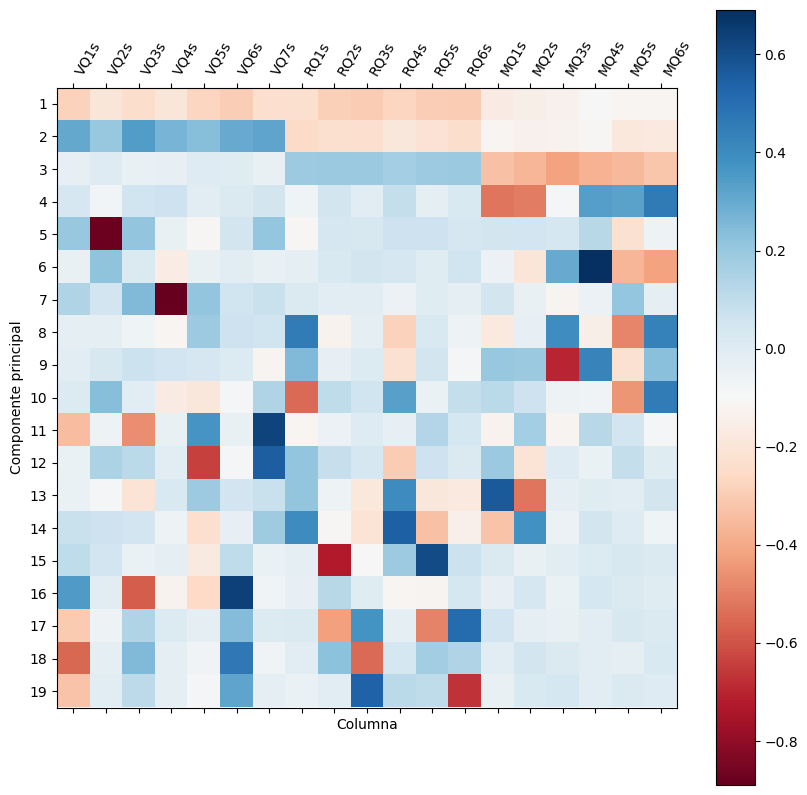

In [6]:
# Graficamos los componentes principales
plt.figure(figsize=(10,10))
plt.matshow(pca_puntaje.components_, cmap='RdBu',  fignum=1)
plt.colorbar()
plt.xticks(range(len(Xpuntaje.columns)), Xpuntaje.columns, rotation=60, ha='left')
plt.yticks(range(pca_puntaje.n_components_), np.arange(pca_puntaje.n_components_)+1)
plt.xlabel("Columna")
plt.ylabel("Componente principal")

**Pregunta 1.3:** En los primeros 3 componentes principales se ve que los pesos a las preguntas de una misma categoría tienen el mismo signo, y diferentes categorías cambian de signo.
¿Qué patrones en las respuestas cree que puede estar reflejando esto? Recuerde que los PC capturan la variabilidad entre personas.
Discuta también la interpretabilidad del resto de los componentes principales.

*Inserte su respuesta aquí*

Un elemento importante del análisis de PCA es cuanta varianza explica cada componente principal.

Grafique cuál es la varianza explicada por cada componente principal.

**Pregunta 1.4:** ¿Cuántos componentes se requieren para explicar el 80% de la varianza?

[ 28.62734092  40.72377713  51.22632407  56.86270885  61.02257846
  65.00119364  68.72910548  72.17988367  75.47681729  78.6836961
  81.63326459  84.4923846   87.26435815  89.8463161   92.13160018
  94.32568004  96.32462239  98.22905215 100.        ]


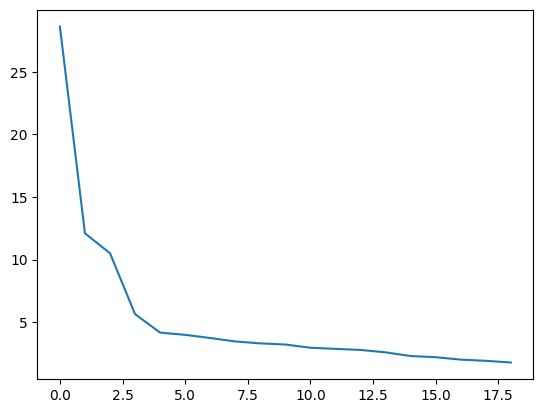

In [7]:
varianzaExplicada = pca_puntaje.explained_variance_ratio_*100 # En esta línea se extrae la varianza explicada por cada PC, en %
#
# Introduzca el código abajo para graficar la varianza que explica cada componente principal
# Puede usar la función plt.plot (vea la documentación en https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html)
# Imprima también el vector 'varianzaExplicada' para ver cuantos componentes se requieren para explicar el 80% de la varianza. Puede
# usar la función para hacer la suma cumulativa: varianzaExplicada.cumsum()


A continuación graficamos los datos, proyectados sobre los primeros 3 componentes principales.

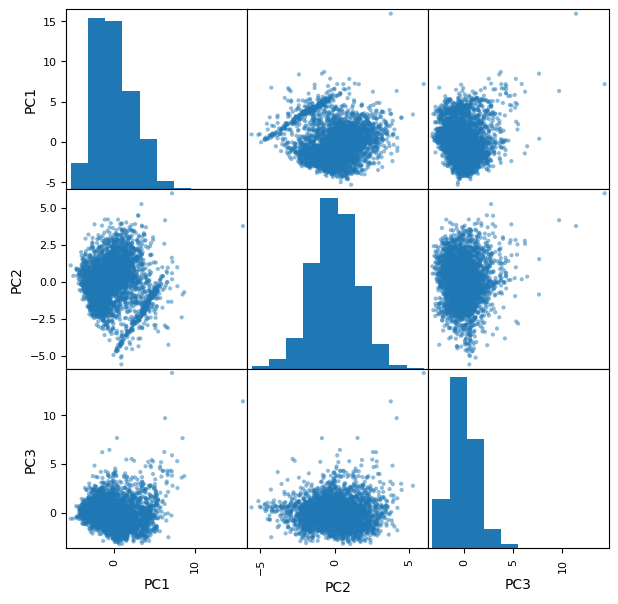

In [8]:
#
# proyectamos (transformamos) los datos sobre
# los dos ejes principales calculados
#
Xpuntaje_pca = pca_puntaje.transform(Xpuntaje)
Xpuntaje_pca = pd.DataFrame(Xpuntaje_pca[:,0:3])
Xpuntaje_pca.columns = ['PC1', 'PC2', 'PC3']
#
grr = pd.plotting.scatter_matrix(Xpuntaje_pca, figsize=(7,7))

**Extra 1.1:** Repita el análisis pero para los **tiempos** en lugar de los puntajes.

In [ ]:
# Puede insertar su código aquí, y crear bloques de código nuevo para hacer el Extra 1.1

## Ejercicio 2: Clustering aglomerativo para identificar especies

En el Taller 2, entrenamos un método de clasificación para identificar especies de pinguinos. Usando un set de datos que incluía la especie, asociamos cada especie con sus características. Supongamos un problema alternativo, donde en una expedición descubrimos una región aislada con varias poblaciones de pinguinos, de especie hasta entonces desconocida (es decir, no conocemos las etiquetas). Sospechamos, sin embargo, que hay más de una especie entre esos pinguinos, probablemente 2 o 3.

Pudimos medir varias características de los pinguinos

In [9]:
import seaborn as sns
penguins = sns.load_dataset('penguins')
penguins = pd.DataFrame(penguins)

penguins = penguins.dropna() # esta línea es para borrar observaciones que les faltan datos
#
# En este caso desechamos la variable de la isla del pinguino, porque sólo queremos
# agruparlos basados en sus características.
penguins = penguins.drop('island', axis=1)
penguins = penguins.drop('sex', axis=1)
#
# También separamos las características de la especie, que usaremos luego
especie = penguins['species']
penguins = penguins.drop('species', axis=1)
#
# Recodificar el sexo en un número, como en el taller 2
#penguins['sex'] = (penguins['sex']=="Female").astype(int)
#
# Y vemos la tabla de datos
penguins.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [10]:
# Estandarizamos los datos
preproc = StandardScaler() # aquí generamos preproc que es una función para estandarizar datos
preproc.fit(penguins) # aquí extraemos los parámetros de Xscore para estandarizar (media, sd)
penguinsNorm = pd.DataFrame(preproc.transform(penguins)) # datos estandarizados
penguinsNorm.columns = penguins.columns # le ponemos nombre a las columnas del nuevo dataframe
#
penguinsNorm.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,-0.896042,0.780732,-1.426752,-0.568475
1,-0.822788,0.119584,-1.069474,-0.506286
2,-0.676280,0.424729,-0.426373,-1.190361
3,-1.335566,1.085877,-0.569284,-0.941606
4,-0.859415,1.747026,-0.783651,-0.692852


_K-means Clustering_ es un algoritmo de aprendizaje no supervisado que intenta agrupar datos a partir de su similaridad.

**Es importante destacar que en este caso, tenemos las etiquetas del dataset de pinguinos, pero NO las usaremos ya que se trata de aplicar un metodo de aprendizaje no supervisado.**

El algoritmo K-means se basa en el calculo de distancias a centroides. Cada cluster (algomeracion, que apuntamos a que este relacionado a las categorias) esta asociado a un centroide, y el objetivo del algoritmo es minimizar la suma de las distancias entre los puntos de data y el centroide del cluster que se le asigna a ese dato.

Con K-means Clustering, tenemos que especificar el numero de clusters K en los que queremos agrupar los datos.


In [11]:
from sklearn.cluster import KMeans

K = 3 # numero de clusters en los cuales queremos agrupar los datos

kmeans = KMeans(K,init='k-means++')
kmeans.fit(penguinsNorm)

/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

/tmp/ipykernel_915670/449558253.py:14: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(C[:,0],C[:,1],color='black',s=tam,cmap=cm.viridis,marker='*')


Text(0.5, 1.0, 'resultado de k-means')

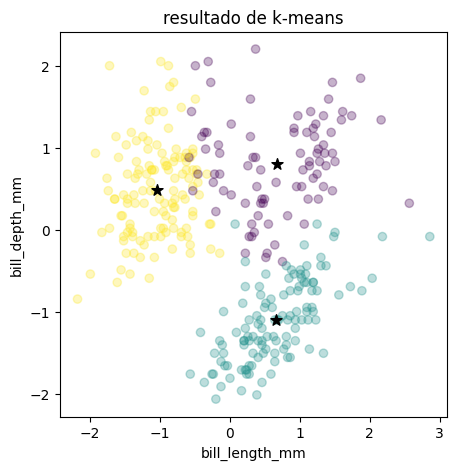

In [12]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# mostramos nubes de puntos con grupos asignados por K-means para las
# dos primeras caracteristicas del dataset: bill_length_mm y bill_depth_mm
t = kmeans.labels_
C = kmeans.cluster_centers_
K = kmeans.n_clusters
colores = np.arange(K)/(K-1)
tam = 70 # tamaño del centroide en pixeles

plt.figure(figsize=(5,5))
plt.scatter(np.array(penguinsNorm)[:,0], np.array(penguinsNorm)[:,1], c=t/K,cmap=cm.viridis,alpha=0.3)
plt.scatter(C[:,0],C[:,1],color='black',s=tam,cmap=cm.viridis,marker='*')
plt.xlabel(penguinsNorm.bill_length_mm.name)
plt.ylabel(penguinsNorm.bill_depth_mm.name)
plt.title('resultado de k-means')

Recuerden que el Kmeans esta entrenado con las 5 caracteristicas, no solo estas dos. Pueden probar de graficar otros pares de caracteristicas!

Continuando con la suposicion de que no tenemos etiquetas de esta base de datos, una forma de intuir que valor de K es optimo es prediciendo para bastantes K y buscando el codo.

/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/p

K 1 score  -1332.0 variación relativa  0%
K 2 score   -552.7 variación relativa 59%
K 3 score   -370.8 variación relativa 33%
K 4 score   -293.9 variación relativa 21%
K 5 score   -228.5 variación relativa 22%
K 6 score   -200.4 variación relativa 12%
K 7 score   -183.3 variación relativa  9%
K 8 score   -166.8 variación relativa  9%
K 9 score   -155.5 variación relativa  7%


/home/dherresp-adm/Packages/miniconda3/envs/my-torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


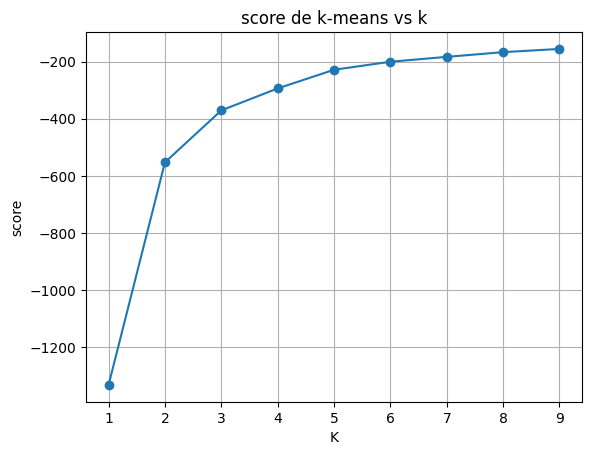

In [13]:
ks = np.arange(1,10)
scores=list()
for K in ks:
  kmeans = KMeans(n_clusters=K)
  kmeans = kmeans.fit(penguinsNorm)
  score = kmeans.score(penguinsNorm)
  if K > 1:
    var = int(np.round(100*(scores[-1]-score)/scores[-1]))
  else:
    var = 0
  print(f'K {K} score {score:8.1f} variación relativa {var:2d}%')
  scores.append(score)

plt.plot(ks,scores,'o-')
plt.grid(True)
plt.xlabel('K')
plt.ylabel('score')
plt.title('score de k-means vs k')
plt.show()

**Pregunta 2.1:** Con el conocimiento previo que tenemos de las categorias de este dataset ¿porque sera que se estabilizan los valores de score, a partir del valor de K que lo hace?

_Escriba su respuesta aqui_

Mas alla de las suposiciones de como esta agrupando el algoritmo, en este caso podemos evaluar su rendimiento ya que en verdad si tenemos etiquetas.

Explique que esta pasando en la _matriz de confusion_ y que informacion nos brinda la misma.

Matriz de confusion: Es una herramienta muy usada en problemas de clasificacion, consiste de una tabla que permite ver el rendimiento de un modelo. Cada fila de la matriz pertenece a una clase verdadera y cada columna a una clase predecida (o viceversa). Y permite ver donde el algoritmo utilizado esta acertando o errando.

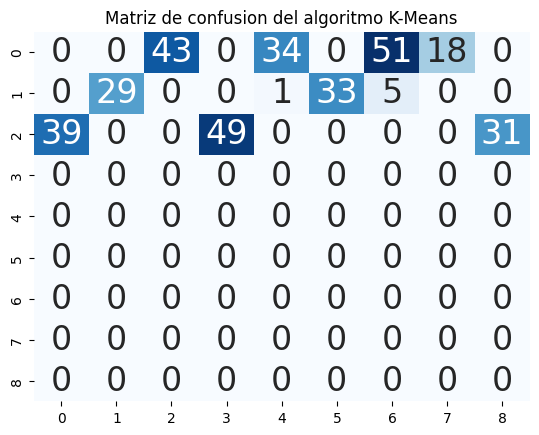

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
# pasamos las especies a una clase numerica para comparar con el resultado de kmeans
especie_cat = especie.astype('category').cat.codes

plt.title("Matriz de confusion del algoritmo K-Means")
sns.heatmap(confusion_matrix(especie_cat,kmeans.labels_),annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
plt.show()